In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

2025-12-13 21:28:05.057289: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 21:28:05.126043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 21:28:06.609499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Reading data from source
df = pd.read_csv(r'/home/aryan/playground/Duplicate Question Detection/data/questions.csv')

In [3]:
# Columns in the dataset
df.columns

Index(['id"', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [4]:
df.head(5)

,"id""",qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# Shape of the data
df.shape

(404351, 6)

In [6]:
# Checking for null values
df.isna().sum()

id"             0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# Dropping null values because its just 3 null values so dropping them is safe
df.dropna(inplace=True)

In [8]:
# Checking for null values
df.duplicated().sum()

np.int64(0)

In [9]:
# Dropping irrelevant columns
df.drop(['id"', 'qid1', 'qid2'], axis=1, inplace=True)

In [10]:
df.head(5)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Text Preprocessing

In [11]:
import contractions
import unicodedata
import nltk
import string
import re
import emoji

In [12]:
# Lower casing the text
df['question1_preprocessed'] = df['question1'].str.lower()
df['question2_preprocessed'] = df['question2'].str.lower()

In [13]:
# Removing http links from the text
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# Apply the function to each text entry
df['question1_preprocessed'] = df['question1_preprocessed'].apply(remove_urls)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(remove_urls)

During the exploratory analysis of our dataset, we observed that very less around 0.05% text entries contain URLs (e.g., https://t.co/...). These links are very important in differentiating question1 from question2 but since they are almost close to negligible so we are removing it.

In [14]:
# Expanding Contractions
df['question1_preprocessed'] = df['question1_preprocessed'].apply(lambda x: contractions.fix(x))
df['question2_preprocessed'] = df['question2_preprocessed'].apply(lambda x: contractions.fix(x))

In [15]:
# Removing Accents/Diacritics
def remove_accents_diacritics(text):
    """
    Normalize unicode text and remove accents/diacritics.
    Example: 'café' → 'cafe'
    """
    # Normalize to 'NFKD' form (decomposes accents)
    text = unicodedata.normalize('NFKD', text)
    # Keep only base characters (ignore diacritics)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    return text

df['question1_preprocessed'] = df['question1_preprocessed'].apply(remove_accents_diacritics)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(remove_accents_diacritics)

In [16]:
# Convert emojis to text descriptions
def convert_emojis(text):
    return emoji.demojize(text)

df['question1_preprocessed'] = df['question1_preprocessed'].apply(convert_emojis)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(convert_emojis)

In [17]:
# Removing punctuations from the text
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['question1_preprocessed'] = df['question1_preprocessed'].apply(remove_punctuation)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(remove_punctuation)

In [18]:
# Converting Raw text into Tokens
from nltk.tokenize import word_tokenize
df['question1_preprocessed'] = df['question1_preprocessed'].apply(lambda x: word_tokenize(x))
df['question2_preprocessed'] = df['question2_preprocessed'].apply(lambda x: word_tokenize(x))

In [19]:
# Lemmetization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

df['question1_preprocessed'] = df['question1_preprocessed'].apply(lemmatize_words)
df['question2_preprocessed'] = df['question2_preprocessed'].apply(lemmatize_words)

In [20]:
df["question1_preprocessed"] = df["question1_preprocessed"].apply(lambda x: " ".join(x))
df["question2_preprocessed"] = df["question2_preprocessed"].apply(lambda x: " ".join(x))

In [21]:
from sklearn.model_selection import train_test_split
X = df[['question1_preprocessed', 'question2_preprocessed']]
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Text Representation

In [22]:
import gensim.downloader as api
print(api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [24]:
glove_model = api.load('glove-twitter-200')

In [ ]:
from keras.layers import TextVectorization, Embedding

vectorizer = TextVectorization(
    max_tokens = 25_000,
    output_mode='int',
    output_sequence_length=30
)

In [ ]:
all_questions = df["question1_preprocessed"].tolist() + df["question2_preprocessed"].tolist()
all_questions = [str(q) for q in all_questions]

In [100]:
vectorizer.adapt(all_questions)

In [101]:
vectorizer.vocabulary_size()

25000

In [237]:
question1_txt = df['question1_preprocessed'].values
question2_txt = df['question2_preprocessed'].values

In [252]:
# Embedding dimension
embedding_dim = glove_model.vector_size

# Vocabulary from TextVectorization
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

matched_words = 0
oov_words = 0

for idx, word in enumerate(vocab):
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]
        matched_words += 1
    else:
        embedding_matrix[idx] = np.random.normal(
            scale=0.6, size=(embedding_dim,)
        )
        oov_words += 1

# Coverage statistics
coverage_percentage = (matched_words / vocab_size) * 100

print("✅ Vocabulary size        :", vocab_size)
print("✅ Matched GloVe words    :", matched_words)
print("❌ OOV (not in model)     :", oov_words)
print(f"📊 GloVe coverage         : {coverage_percentage:.2f}%")

✅ Vocabulary size        : 25000
✅ Matched GloVe words    : 21560
❌ OOV (not in model)     : 3440
📊 GloVe coverage         : 86.24%


In [253]:
# These are the dense vectors of each word taken from pretrained glove model each word is represented with 100 dense vectors
embedding_matrix.shape

(25000, 200)

In [254]:
from keras.layers import Embedding
import keras

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
    mask_zero=False
)

# Using special siamese lstm model for text similarity

In [255]:
from keras.layers import (
    Input, 
    Bidirectional, 
    LSTM, 
    GlobalMaxPooling1D, 
    Dense, 
    Dropout, 
    Lambda, 
    BatchNormalization, 
    LayerNormalization, 
    GlobalAveragePooling1D, 
    Concatenate
)
from keras.models import Model
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler


In [256]:
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.optimizers import Nadam

# Inputs
q1_input = Input(shape=(), dtype=tf.string, name="q1")
q2_input = Input(shape=(), dtype=tf.string, name="q2")

# Vectorization
q1_int = vectorizer(q1_input)
q2_int = vectorizer(q2_input)

# Shared Encoder
max_len = 30
encoder_input = Input(shape=(max_len,), dtype="int32")

x = embedding_layer(encoder_input)

x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Bidirectional(LSTM(16, return_sequences=True))(x)
x = Bidirectional(LSTM(8, return_sequences=True))(x)
x = Bidirectional(LSTM(4))(x)


x = Dense(32, activation="elu", kernel_initializer='he_normal')(x)
x = Dense(16, activation="elu", kernel_initializer='he_normal')(x)
x = Dense(8, activation="elu", kernel_initializer='he_normal')(x)
x = Dense(4, activation="elu", kernel_initializer='he_normal')(x)
encoder = Model(encoder_input, x, name="shared_encoder")

# Encode
q1_vec = encoder(q1_int)
q2_vec = encoder(q2_int)

# Absolute difference
abs_diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([q1_vec, q2_vec])

# Similarity head
x = Dense(32, activation="elu", kernel_initializer='he_normal')(abs_diff)
x = Dense(16, activation="elu", kernel_initializer='he_normal')(abs_diff)
x = Dense(8, activation="elu", kernel_initializer='he_normal')(abs_diff)
x = Dense(4, activation="elu", kernel_initializer='he_normal')(abs_diff)
x = Dropout(0.7)(x) 
output = Dense(1, activation="sigmoid", name="similarity")(x)

# Final model
siamese_model = Model([q1_input, q2_input], output)

# Compile
siamese_model.compile(
    optimizer=Nadam(),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc")
    ]
)

siamese_model.summary(show_trainable=True)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ q1 (InputLayer)   │ (None)          │         0 │ -              │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ q2 (InputLayer)   │ (None)          │         0 │ -              │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ text_vectorizati… │ (None, 30)      │         0 │ q1[0][0],      │   -   │
│ (TextVectorizati… │                 │           │ q2[0][0]       │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_encoder    │ (None, 4)       │ 5,074,300 │ text_vectoriz… │   Y   │
│ (Functional)      │                 │           │ text_vectoriz… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ lambda_24         │ (None, 4)       │         0 │ shared_encode… │   -   │
│ (Lambda)          │                 │           │ shared_encode… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_79 (Dense)  │ (None, 4)       │        20 │ lambda_24[0][… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_24        │ (None, 4)       │         0 │ dense_79[0][0] │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ similarity        │ (None, 1)       │         5 │ dropout_24[0]… │   Y   │
│ (Dense)           │                 │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 5,074,325 (19.36 MB)

 Trainable params: 5,074,325 (19.36 MB)

 Non-trainable params: 0 (0.00 B)

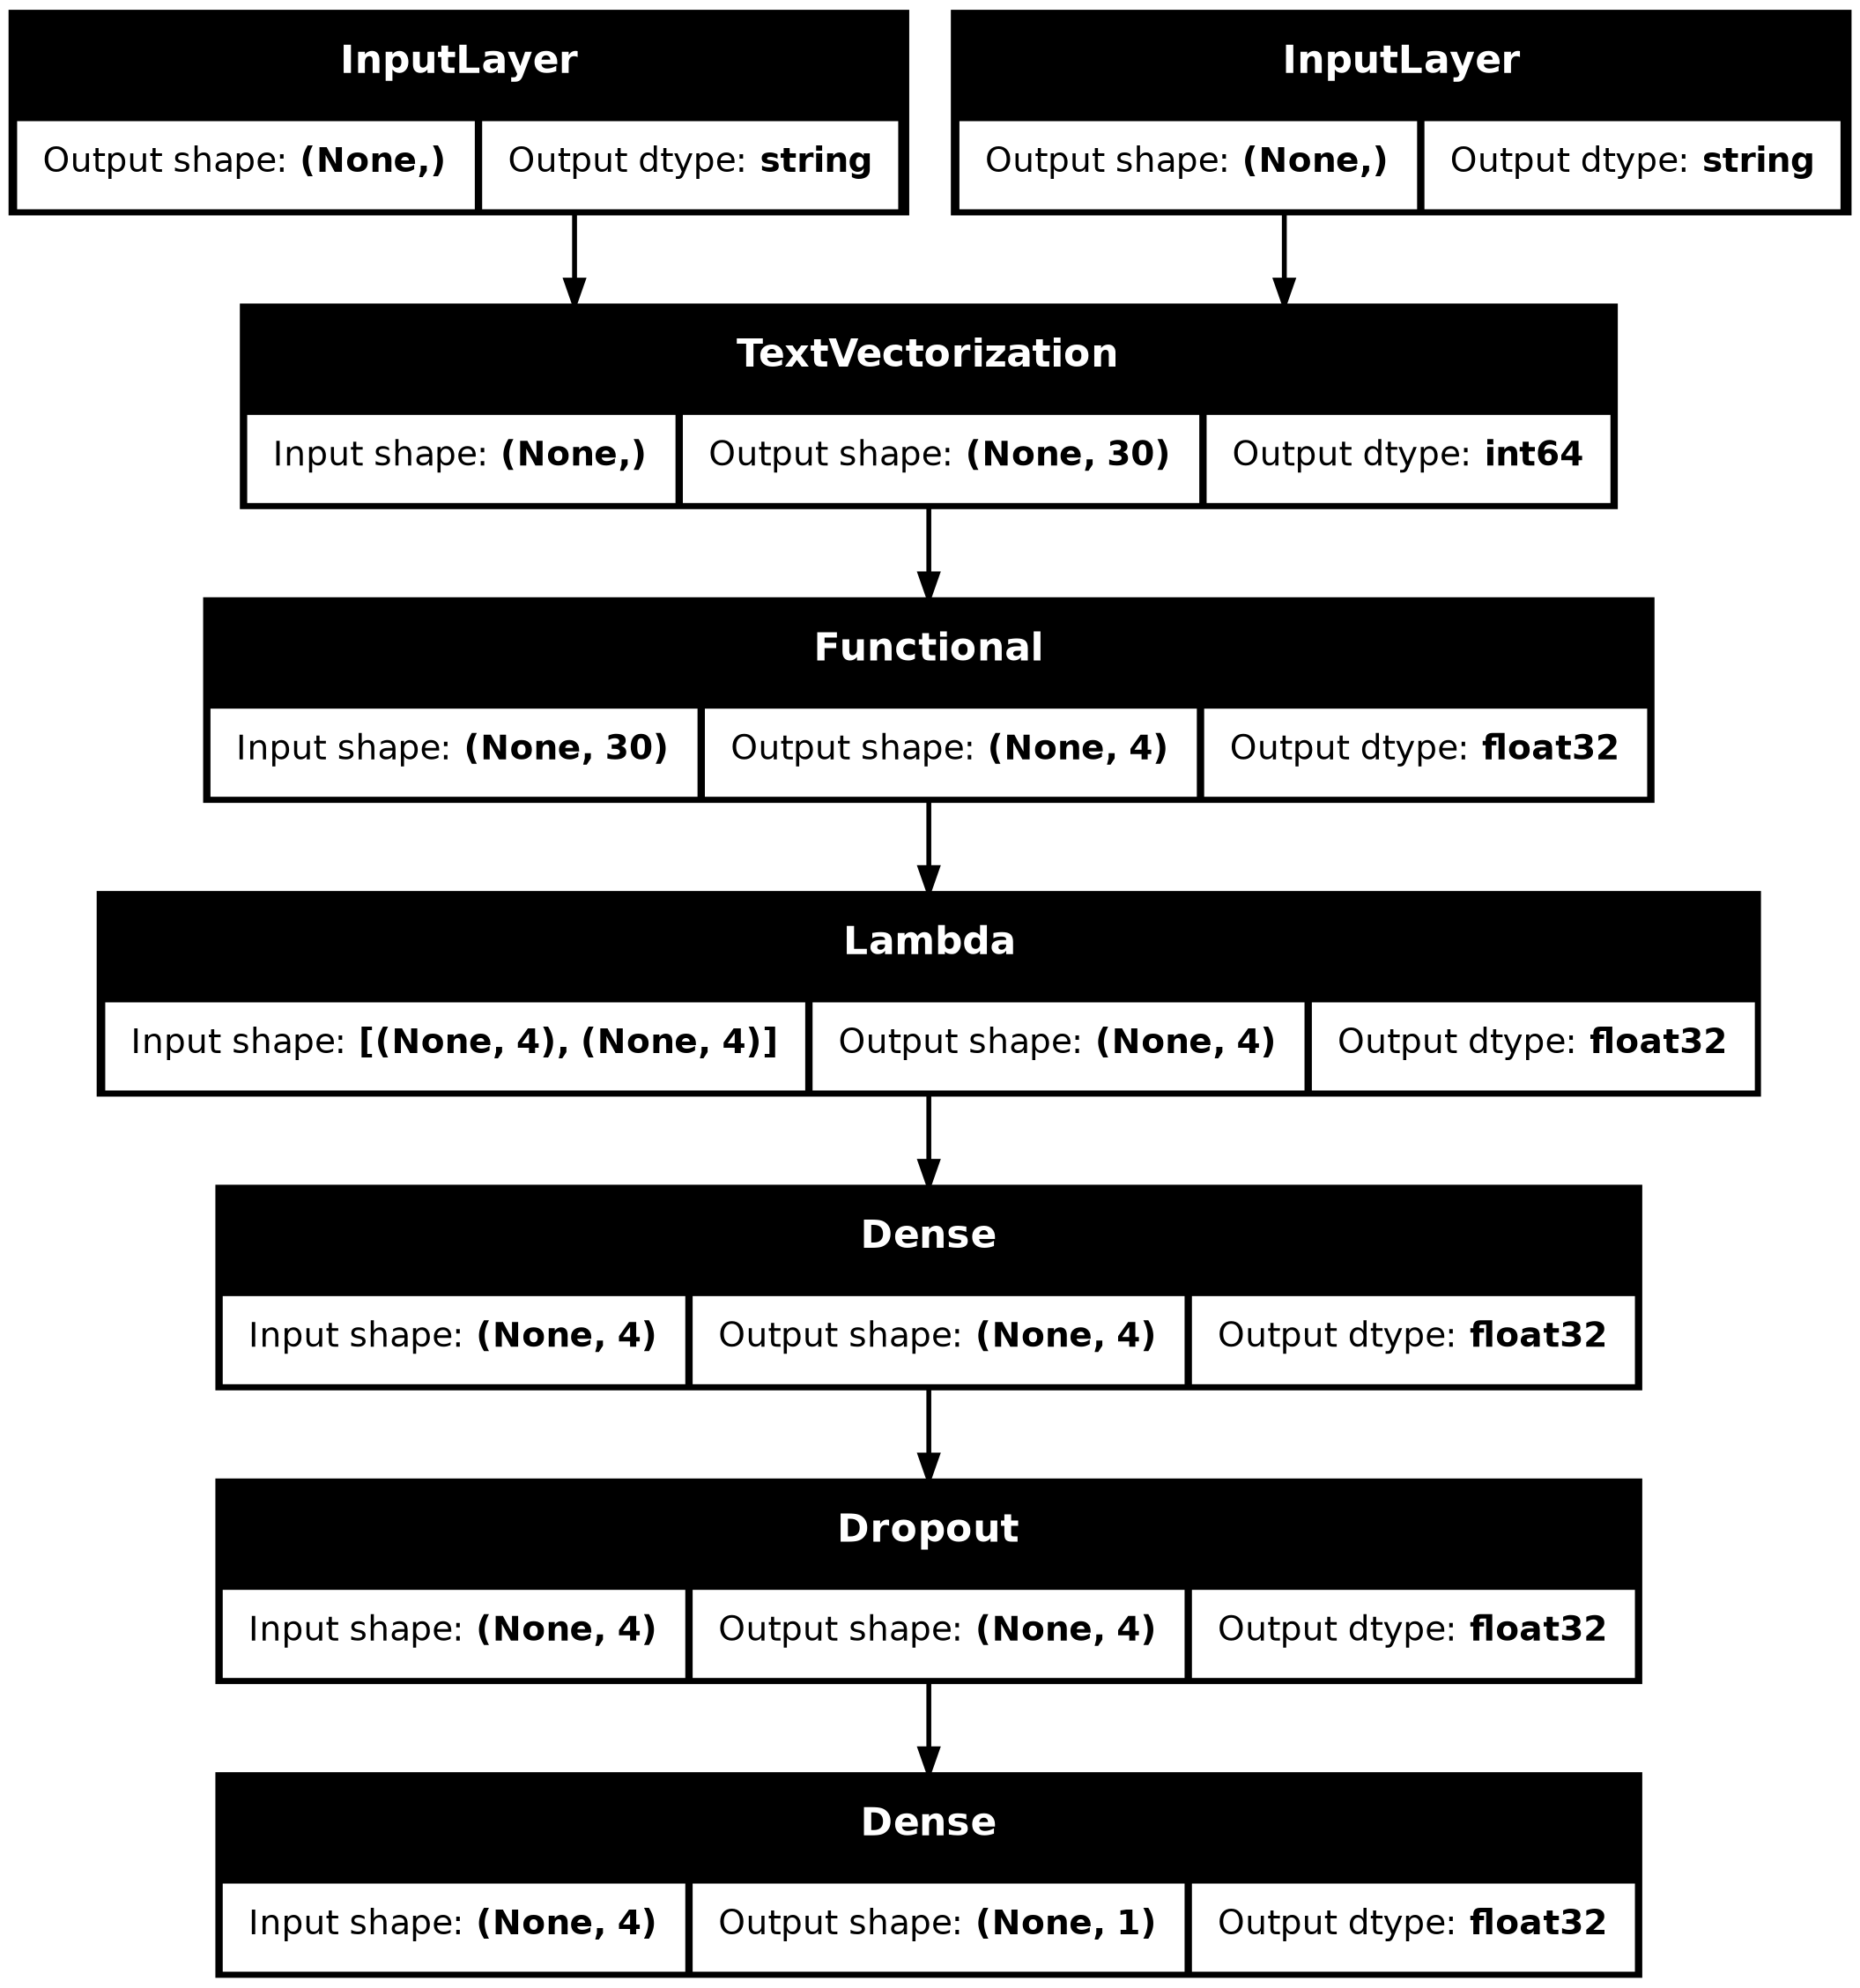

In [257]:
from keras.utils import plot_model
plot_model(siamese_model, show_dtype=True, show_shapes=True)

In [258]:
print(X_train.shape)
print(X_test.shape)

(323478, 2)
(80870, 2)


In [259]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {i: weights[i] for i in range(len(weights))}
print(class_weight)


{0: np.float64(0.7927086519083132), 1: np.float64(1.3540915971226877)}


In [260]:
early_stop = EarlyStopping(
    monitor="val_auc",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=5,
    min_delta=1e-2,
    verbose=1
)

In [ ]:
q1_train = df['question1_preprocessed'].values
q2_train = df['question2_preprocessed'].values
y_train  = df['is_duplicate'].values

history = siamese_model.fit(
    [q1_train, q2_train],
    y_train,
    batch_size=256,
    epochs=20,
    validation_split=0.3,
    class_weight=class_weight,
    callbacks=[early_stop]
)

In [262]:
X_test.shape

(80870, 2)

In [263]:
q1_test = tf.constant(X_test[:, 0])
q2_test = tf.constant(X_test[:, 1])

siamese_model.evaluate(
    {"q1": q1_test, "q2": q2_test},
    y_test,
    batch_size=32
)

2528/2528 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - auc: 0.9190 - loss: 0.3648


[0.36478757858276367, 0.9190124869346619]

In [ ]:
y_scores = siamese_model.predict(
    {"q1": q1_test, "q2": q2_test},
    batch_size=32
).ravel()

2528/2528 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step


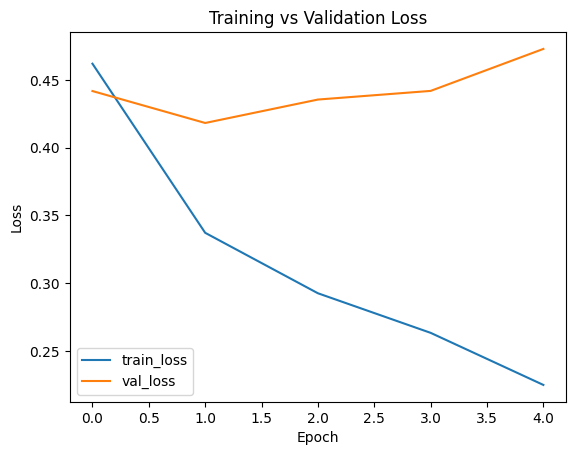

In [264]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

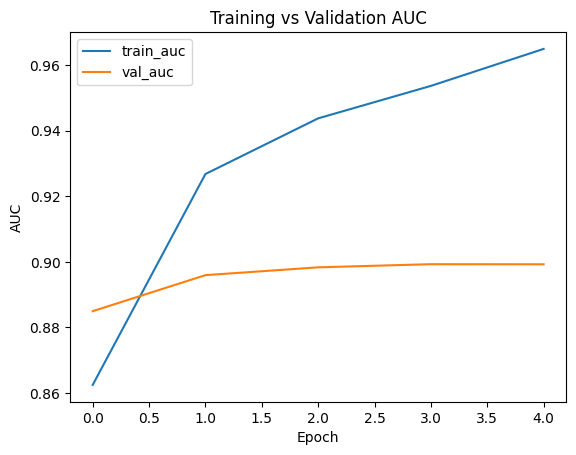

In [265]:
plt.figure()
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.title("Training vs Validation AUC")
plt.show()

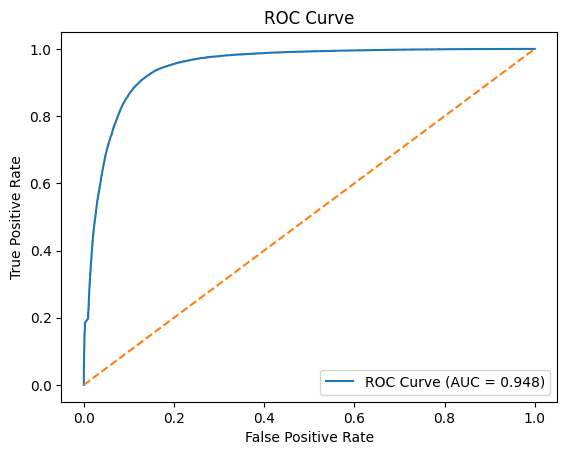

In [266]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [267]:
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("TPR (Recall):", tpr[best_idx])
print("FPR:", fpr[best_idx])

Best threshold: 0.5188509
TPR (Recall): 0.9190917919694584
FPR: 0.13936756258699445


In [268]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

best_threshold = best_threshold

y_pred_final = (y_scores >= best_threshold).astype(int)

print("Precision:", precision_score(y_test, y_pred_final))
print("Recall:", recall_score(y_test, y_pred_final))
print("F1 Score:", f1_score(y_test, y_pred_final))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


Precision: 0.7942640504717254
Recall: 0.9190917919694584
F1 Score: 0.8521307148955989

Confusion Matrix:
[[43900  7109]
 [ 2416 27445]]
